In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler

import diff_pipeline4__config as cfg

from diff_pipeline4__dataset_simple_no_embs import DiffPipeline4SameUniformDiffDataset, DiffPipeline4MixedUniformDiffDataset, DiffPipeline4MimicDiffDataset, get_error_constrained_dataset
from Common.Datasets.Morph2.data_parser import DataParser
from diff_pipeline4__train import train_diff_cls_model_iter


from diff_pipeline4__model import DiffPipeline4Model, DiffPipeline4DeepModel, AgeDiffModel, DiffModelConfigType

from tqdm import tqdm

from sklearn import utils



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

# if cfg.USE_GPU:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# else:
device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

with open("im2age_map_test.json", 'r') as im2age_map_test_f:
    im2age_map_test = json.load(im2age_map_test_f)

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)


cpu


In [2]:
import matplotlib.pyplot as plt

In [3]:
face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)
#     import pdb
#     pdb.set_trace()
#face2emb_arr_trn_r = face2emb_arr_trn_r.item()

face2emb_arr_vld_r = np.load('face2emb_arr_vld.npy', allow_pickle=True)
#face2emb_arr_vld_r = face2emb_arr_vld_r.item()

# shuffle basic aligned test
# x_test_shuffled
# y_test_shuffled


transf = transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5,
            resample=Image.BICUBIC
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ])

# transf = transforms.Compose([
#         transforms.Resize(224), # just for testing
# #          transforms.RandomResizedCrop(224, (0.9, 1.0)),
# #          transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1
#         )], p=0.5),
# #         transforms.RandomApply([transforms.RandomAffine(
# #             degrees=10,
# #             translate=(0.1, 0.1),
# #             scale=(0.9, 1.1),
# #             shear=5,
# #             resample=Image.BICUBIC
# #         )], p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# #        transforms.RandomErasing(p=0.5)
# ])

train_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_trn_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

test_qtst_rtst_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_test,
    data_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

test_qtst_rtrn_ds = DiffPipeline4MixedUniformDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test,
    batst_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                im2age_map_batst=im2age_map_test)

# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = DiffPipeline4MimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))

x_test_all, y_test_all, batst_set_all_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=3,#35,#cfg.AGE_RADIUS,
                                                                                                im2age_map_batst=im2age_map_test)


# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
# test_apref_all_ds = DiffPipeline4MimicDiffDataset(
# 	batrn_set_images=x_train,
# 	batrn_set_metadata=y_train,
#     batst_set_images=x_test_all,
#     batst_set_metadata=y_test_all,
#     batst_set_indexes=batst_set_all_indexes,
#     im2age_map_batst=im2age_map_test,
# 	min_age=cfg.MIN_AGE,
# 	age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
# 	transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     embs_trn=face2emb_arr_trn_r,
#     embs_vld=face2emb_arr_vld_r#,
#     #num_references=cfg.NUM_OF_REFS
# )

# print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=35) + str(len(test_apref_all_ds))) #cfg.AGE_RADIUS





image_datasets = {
    'train': train_ds,
    'val_qtst_rtst': test_qtst_rtst_ds,
    'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds,
    #'val_apref_all_ds': test_apref_all_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val_qtst_rtst', 'val_qtst_rtrn', 'val_apref_ds']}#, 'val_apref_all_ds']}

data_loaders = {
    'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
    'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    #'val_apref_all_ds' : DataLoader(test_apref_all_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}

C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torchvision\transforms\transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Training (q trn, r trn) set size: 44285
Testing (q tst, r tst) set size: 10606
Testing (q tst, r trn) set size: 10606
Testing (q tst where AgePredict(q)  0 <= error <= 35, r trn where age(r)=AgePredict(q)) set size: 7012


In [4]:
from tqdm import tqdm

total_sample = np.array([])
for i, batch in enumerate(tqdm(data_loaders['train'])):
    total_sample = np.concatenate((total_sample, batch['age_diff'].numpy()))
    if i % 5 == 0:
        print(np.histogram(total_sample, bins=[-3,-2,-1,0,1,2,3]))

  0%|                                                                                 | 1/1383 [00:00<19:34,  1.18it/s]

(array([ 4,  5,  5,  4,  3, 11], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  0%|▎                                                                                | 6/1383 [00:03<14:01,  1.64it/s]

(array([27, 26, 21, 35, 25, 58], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  1%|▋                                                                               | 11/1383 [00:06<12:33,  1.82it/s]

(array([ 45,  48,  43,  61,  54, 101], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  1%|▉                                                                               | 16/1383 [00:09<12:14,  1.86it/s]

(array([ 61,  67,  71,  86,  84, 143], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  2%|█▏                                                                              | 21/1383 [00:12<12:50,  1.77it/s]

(array([ 85,  86,  94, 110, 111, 186], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  2%|█▌                                                                              | 26/1383 [00:14<12:39,  1.79it/s]

(array([104, 110, 119, 137, 133, 229], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  2%|█▊                                                                              | 31/1383 [00:17<13:07,  1.72it/s]

(array([132, 124, 149, 161, 156, 270], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  3%|██                                                                              | 36/1383 [00:20<11:48,  1.90it/s]

(array([148, 144, 176, 180, 186, 318], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  3%|██▎                                                                             | 41/1383 [00:23<11:58,  1.87it/s]

(array([169, 165, 192, 203, 221, 362], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  3%|██▋                                                                             | 46/1383 [00:25<11:53,  1.87it/s]

(array([193, 187, 220, 228, 245, 399], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  4%|██▉                                                                             | 51/1383 [00:28<11:55,  1.86it/s]

(array([210, 208, 246, 247, 279, 442], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  4%|███▏                                                                            | 56/1383 [00:31<12:19,  1.80it/s]

(array([230, 232, 269, 264, 307, 490], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  4%|███▌                                                                            | 61/1383 [00:34<12:31,  1.76it/s]

(array([257, 251, 288, 281, 334, 541], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  5%|███▊                                                                            | 66/1383 [00:36<12:13,  1.80it/s]

(array([284, 264, 309, 310, 357, 588], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  5%|████                                                                            | 71/1383 [00:39<11:30,  1.90it/s]

(array([303, 295, 338, 324, 380, 632], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  5%|████▍                                                                           | 76/1383 [00:42<11:22,  1.92it/s]

(array([318, 317, 364, 349, 405, 679], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  6%|████▋                                                                           | 81/1383 [00:44<11:41,  1.86it/s]

(array([335, 338, 383, 374, 423, 739], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  6%|████▉                                                                           | 86/1383 [00:47<11:30,  1.88it/s]

(array([357, 359, 410, 396, 444, 786], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  7%|█████▎                                                                          | 91/1383 [00:50<12:36,  1.71it/s]

(array([372, 381, 434, 432, 464, 829], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  7%|█████▌                                                                          | 96/1383 [00:53<11:52,  1.81it/s]

(array([391, 406, 459, 454, 488, 874], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  7%|█████▊                                                                         | 101/1383 [00:55<11:08,  1.92it/s]

(array([415, 433, 486, 479, 503, 916], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  8%|██████                                                                         | 106/1383 [00:58<11:30,  1.85it/s]

(array([433, 453, 507, 505, 534, 960], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  8%|██████▎                                                                        | 111/1383 [01:01<11:43,  1.81it/s]

(array([459, 477, 532, 525, 560, 999], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  8%|██████▋                                                                        | 116/1383 [01:04<11:55,  1.77it/s]

(array([ 487,  505,  557,  541,  583, 1039], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  9%|██████▉                                                                        | 121/1383 [01:06<10:51,  1.94it/s]

(array([ 516,  533,  572,  565,  600, 1086], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  9%|███████▏                                                                       | 126/1383 [01:09<10:56,  1.92it/s]

(array([ 538,  556,  596,  589,  619, 1134], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


  9%|███████▍                                                                       | 131/1383 [01:12<12:27,  1.67it/s]

(array([ 561,  580,  622,  609,  646, 1174], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 10%|███████▊                                                                       | 136/1383 [01:15<11:30,  1.81it/s]

(array([ 579,  598,  653,  637,  668, 1217], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 10%|████████                                                                       | 141/1383 [01:17<10:50,  1.91it/s]

(array([ 601,  615,  685,  652,  688, 1271], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 11%|████████▎                                                                      | 146/1383 [01:20<10:43,  1.92it/s]

(array([ 620,  633,  706,  681,  716, 1316], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 11%|████████▋                                                                      | 151/1383 [01:23<10:51,  1.89it/s]

(array([ 642,  653,  725,  704,  743, 1365], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 11%|████████▉                                                                      | 156/1383 [01:25<10:43,  1.91it/s]

(array([ 665,  678,  749,  729,  761, 1410], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 12%|█████████▏                                                                     | 161/1383 [01:28<10:59,  1.85it/s]

(array([ 687,  699,  775,  750,  779, 1462], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 12%|█████████▍                                                                     | 166/1383 [01:31<11:21,  1.79it/s]

(array([ 708,  716,  798,  778,  797, 1515], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 12%|█████████▊                                                                     | 171/1383 [01:33<10:53,  1.85it/s]

(array([ 729,  735,  821,  798,  815, 1574], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 13%|██████████                                                                     | 176/1383 [01:36<11:35,  1.73it/s]

(array([ 746,  761,  850,  818,  840, 1617], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 13%|██████████▎                                                                    | 181/1383 [01:39<11:19,  1.77it/s]

(array([ 760,  787,  873,  843,  864, 1665], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 13%|██████████▌                                                                    | 186/1383 [01:42<10:53,  1.83it/s]

(array([ 777,  812,  898,  860,  883, 1722], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 14%|██████████▉                                                                    | 191/1383 [01:45<10:57,  1.81it/s]

(array([ 801,  843,  918,  877,  900, 1773], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 14%|███████████▏                                                                   | 196/1383 [01:48<11:22,  1.74it/s]

(array([ 819,  861,  936,  903,  917, 1836], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 15%|███████████▍                                                                   | 201/1383 [01:50<11:03,  1.78it/s]

(array([ 839,  888,  957,  927,  947, 1874], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 15%|███████████▊                                                                   | 206/1383 [01:53<10:26,  1.88it/s]

(array([ 862,  917,  976,  959,  965, 1913], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 15%|████████████                                                                   | 211/1383 [01:56<10:34,  1.85it/s]

(array([ 878,  947, 1001,  978,  996, 1952], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 16%|████████████▎                                                                  | 216/1383 [01:59<10:46,  1.80it/s]

(array([ 899,  967, 1017, 1011, 1024, 1994], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 16%|████████████▌                                                                  | 221/1383 [02:01<11:10,  1.73it/s]

(array([ 913,  989, 1035, 1039, 1049, 2047], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 16%|████████████▉                                                                  | 226/1383 [02:04<11:21,  1.70it/s]

(array([ 929, 1011, 1058, 1062, 1075, 2097], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 17%|█████████████▏                                                                 | 231/1383 [02:07<11:16,  1.70it/s]

(array([ 956, 1033, 1077, 1087, 1104, 2135], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 17%|█████████████▍                                                                 | 236/1383 [02:10<10:56,  1.75it/s]

(array([ 976, 1064, 1103, 1107, 1124, 2178], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 17%|█████████████▊                                                                 | 241/1383 [02:13<10:54,  1.75it/s]

(array([1001, 1088, 1129, 1132, 1143, 2219], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 18%|██████████████                                                                 | 246/1383 [02:16<10:33,  1.79it/s]

(array([1017, 1116, 1149, 1156, 1167, 2267], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 18%|██████████████▎                                                                | 251/1383 [02:18<10:23,  1.82it/s]

(array([1046, 1130, 1173, 1178, 1185, 2320], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 19%|██████████████▌                                                                | 256/1383 [02:21<10:04,  1.86it/s]

(array([1067, 1148, 1190, 1195, 1214, 2378], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 19%|██████████████▉                                                                | 261/1383 [02:24<09:32,  1.96it/s]

(array([1081, 1164, 1216, 1223, 1236, 2432], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 19%|███████████████▏                                                               | 266/1383 [02:26<09:58,  1.87it/s]

(array([1104, 1189, 1245, 1250, 1252, 2472], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 20%|███████████████▍                                                               | 271/1383 [02:29<10:41,  1.73it/s]

(array([1128, 1215, 1261, 1275, 1279, 2514], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 20%|███████████████▊                                                               | 276/1383 [02:32<10:22,  1.78it/s]

(array([1145, 1238, 1281, 1303, 1304, 2561], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 20%|████████████████                                                               | 281/1383 [02:35<09:27,  1.94it/s]

(array([1165, 1258, 1306, 1330, 1327, 2606], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 21%|████████████████▎                                                              | 286/1383 [02:37<10:00,  1.83it/s]

(array([1182, 1278, 1332, 1353, 1354, 2653], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 21%|████████████████▌                                                              | 291/1383 [02:40<10:29,  1.73it/s]

(array([1209, 1302, 1358, 1369, 1374, 2700], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 21%|████████████████▉                                                              | 296/1383 [02:43<10:10,  1.78it/s]

(array([1232, 1326, 1383, 1388, 1401, 2742], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 22%|█████████████████▏                                                             | 301/1383 [02:46<09:56,  1.81it/s]

(array([1258, 1349, 1403, 1412, 1429, 2781], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 22%|█████████████████▍                                                             | 306/1383 [02:49<10:10,  1.76it/s]

(array([1272, 1368, 1429, 1433, 1457, 2833], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 22%|█████████████████▊                                                             | 311/1383 [02:51<09:39,  1.85it/s]

(array([1292, 1389, 1456, 1460, 1484, 2871], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 23%|██████████████████                                                             | 316/1383 [02:54<09:38,  1.85it/s]

(array([1310, 1410, 1493, 1484, 1506, 2909], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 23%|██████████████████▎                                                            | 321/1383 [02:57<09:30,  1.86it/s]

(array([1342, 1427, 1514, 1510, 1526, 2953], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 24%|██████████████████▌                                                            | 326/1383 [03:00<09:29,  1.86it/s]

(array([1364, 1448, 1538, 1538, 1548, 2996], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 24%|██████████████████▉                                                            | 331/1383 [03:02<09:57,  1.76it/s]

(array([1385, 1469, 1564, 1566, 1575, 3033], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 24%|███████████████████▏                                                           | 336/1383 [03:05<09:36,  1.82it/s]

(array([1402, 1486, 1585, 1585, 1603, 3091], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 25%|███████████████████▍                                                           | 341/1383 [03:08<09:47,  1.77it/s]

(array([1426, 1516, 1605, 1605, 1615, 3145], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 25%|███████████████████▊                                                           | 346/1383 [03:11<09:18,  1.86it/s]

(array([1452, 1533, 1625, 1632, 1639, 3191], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 25%|████████████████████                                                           | 351/1383 [03:13<09:32,  1.80it/s]

(array([1469, 1553, 1655, 1655, 1659, 3241], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 26%|████████████████████▎                                                          | 356/1383 [03:16<09:27,  1.81it/s]

(array([1496, 1572, 1684, 1678, 1684, 3278], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 26%|████████████████████▌                                                          | 361/1383 [03:19<09:32,  1.78it/s]

(array([1514, 1599, 1719, 1704, 1702, 3314], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 26%|████████████████████▉                                                          | 366/1383 [03:22<09:12,  1.84it/s]

(array([1533, 1622, 1746, 1736, 1726, 3349], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 27%|█████████████████████▏                                                         | 371/1383 [03:24<08:43,  1.93it/s]

(array([1550, 1643, 1770, 1762, 1749, 3398], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 27%|█████████████████████▍                                                         | 376/1383 [03:27<09:05,  1.85it/s]

(array([1570, 1669, 1792, 1784, 1776, 3441], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 28%|█████████████████████▊                                                         | 381/1383 [03:30<09:18,  1.80it/s]

(array([1594, 1697, 1814, 1802, 1801, 3484], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 28%|██████████████████████                                                         | 386/1383 [03:33<09:02,  1.84it/s]

(array([1621, 1719, 1837, 1827, 1828, 3520], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 28%|██████████████████████▎                                                        | 391/1383 [03:35<09:02,  1.83it/s]

(array([1638, 1742, 1861, 1848, 1854, 3569], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 29%|██████████████████████▌                                                        | 396/1383 [03:38<09:09,  1.79it/s]

(array([1659, 1759, 1887, 1875, 1880, 3612], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 29%|██████████████████████▉                                                        | 401/1383 [03:41<08:41,  1.88it/s]

(array([1685, 1779, 1909, 1901, 1896, 3662], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 29%|███████████████████████▏                                                       | 406/1383 [03:44<09:23,  1.73it/s]

(array([1703, 1797, 1937, 1931, 1921, 3703], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 30%|███████████████████████▍                                                       | 411/1383 [03:46<09:08,  1.77it/s]

(array([1724, 1818, 1961, 1961, 1938, 3750], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 30%|███████████████████████▊                                                       | 416/1383 [03:49<09:20,  1.72it/s]

(array([1744, 1842, 1989, 1985, 1963, 3789], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 30%|████████████████████████                                                       | 421/1383 [03:52<09:00,  1.78it/s]

(array([1764, 1864, 2010, 2016, 1984, 3834], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 31%|████████████████████████▎                                                      | 426/1383 [03:55<08:49,  1.81it/s]

(array([1782, 1878, 2039, 2045, 2008, 3880], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 31%|████████████████████████▌                                                      | 431/1383 [03:58<08:50,  1.80it/s]

(array([1805, 1893, 2066, 2063, 2031, 3934], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 32%|████████████████████████▉                                                      | 436/1383 [04:00<08:59,  1.76it/s]

(array([1830, 1916, 2090, 2084, 2055, 3977], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 32%|█████████████████████████▏                                                     | 441/1383 [04:03<08:39,  1.81it/s]

(array([1844, 1940, 2106, 2113, 2085, 4024], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 32%|█████████████████████████▍                                                     | 446/1383 [04:06<08:42,  1.79it/s]

(array([1872, 1971, 2120, 2137, 2108, 4064], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 33%|█████████████████████████▊                                                     | 451/1383 [04:09<08:38,  1.80it/s]

(array([1896, 1992, 2139, 2166, 2136, 4103], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 33%|██████████████████████████                                                     | 456/1383 [04:12<08:54,  1.73it/s]

(array([1915, 2013, 2169, 2194, 2158, 4143], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 33%|██████████████████████████▎                                                    | 461/1383 [04:14<08:41,  1.77it/s]

(array([1941, 2033, 2187, 2220, 2178, 4193], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 34%|██████████████████████████▌                                                    | 466/1383 [04:17<08:47,  1.74it/s]

(array([1962, 2052, 2217, 2242, 2197, 4242], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 34%|██████████████████████████▉                                                    | 471/1383 [04:20<08:27,  1.80it/s]

(array([1984, 2070, 2250, 2269, 2210, 4289], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 34%|███████████████████████████▏                                                   | 476/1383 [04:23<08:39,  1.75it/s]

(array([2009, 2096, 2273, 2297, 2228, 4329], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 35%|███████████████████████████▍                                                   | 481/1383 [04:25<08:02,  1.87it/s]

(array([2035, 2112, 2296, 2320, 2243, 4386], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 35%|███████████████████████████▊                                                   | 486/1383 [04:28<08:26,  1.77it/s]

(array([2059, 2137, 2320, 2343, 2259, 4434], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 36%|████████████████████████████                                                   | 491/1383 [04:31<08:23,  1.77it/s]

(array([2089, 2167, 2342, 2363, 2276, 4475], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 36%|████████████████████████████▎                                                  | 496/1383 [04:34<08:19,  1.77it/s]

(array([2113, 2189, 2364, 2391, 2294, 4521], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 36%|████████████████████████████▌                                                  | 501/1383 [04:37<08:04,  1.82it/s]

(array([2133, 2208, 2392, 2414, 2323, 4562], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 37%|████████████████████████████▉                                                  | 506/1383 [04:39<08:03,  1.81it/s]

(array([2162, 2230, 2413, 2442, 2340, 4605], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 37%|█████████████████████████████▏                                                 | 511/1383 [04:42<07:59,  1.82it/s]

(array([2186, 2248, 2439, 2468, 2368, 4643], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 37%|█████████████████████████████▍                                                 | 516/1383 [04:45<07:51,  1.84it/s]

(array([2200, 2271, 2463, 2495, 2389, 4694], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 38%|█████████████████████████████▊                                                 | 521/1383 [04:48<08:10,  1.76it/s]

(array([2215, 2290, 2491, 2519, 2413, 4744], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 38%|██████████████████████████████                                                 | 526/1383 [04:51<07:51,  1.82it/s]

(array([2236, 2312, 2515, 2535, 2439, 4795], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 38%|██████████████████████████████▎                                                | 531/1383 [04:54<08:09,  1.74it/s]

(array([2257, 2330, 2542, 2554, 2455, 4854], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 39%|██████████████████████████████▌                                                | 536/1383 [04:56<07:48,  1.81it/s]

(array([2273, 2361, 2555, 2586, 2468, 4909], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 39%|██████████████████████████████▉                                                | 541/1383 [04:59<07:42,  1.82it/s]

(array([2298, 2382, 2579, 2608, 2484, 4961], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 39%|███████████████████████████████▏                                               | 546/1383 [05:02<07:52,  1.77it/s]

(array([2327, 2403, 2602, 2629, 2511, 5000], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 40%|███████████████████████████████▍                                               | 551/1383 [05:05<07:57,  1.74it/s]

(array([2337, 2427, 2621, 2659, 2536, 5052], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 40%|███████████████████████████████▊                                               | 556/1383 [05:08<07:42,  1.79it/s]

(array([2357, 2452, 2643, 2682, 2555, 5103], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 41%|████████████████████████████████                                               | 561/1383 [05:11<07:45,  1.77it/s]

(array([2383, 2470, 2671, 2702, 2579, 5147], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 41%|████████████████████████████████▎                                              | 566/1383 [05:13<07:40,  1.77it/s]

(array([2412, 2495, 2705, 2721, 2599, 5180], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 41%|████████████████████████████████▌                                              | 571/1383 [05:16<07:52,  1.72it/s]

(array([2430, 2522, 2724, 2744, 2630, 5222], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 42%|████████████████████████████████▉                                              | 576/1383 [05:19<07:34,  1.78it/s]

(array([2443, 2551, 2747, 2772, 2658, 5261], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 42%|█████████████████████████████████▏                                             | 581/1383 [05:22<07:25,  1.80it/s]

(array([2465, 2581, 2765, 2795, 2679, 5307], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 42%|█████████████████████████████████▍                                             | 586/1383 [05:25<07:32,  1.76it/s]

(array([2484, 2610, 2787, 2810, 2700, 5361], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 43%|█████████████████████████████████▊                                             | 591/1383 [05:27<07:10,  1.84it/s]

(array([2499, 2631, 2815, 2828, 2726, 5413], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 43%|██████████████████████████████████                                             | 596/1383 [05:30<07:11,  1.82it/s]

(array([2521, 2651, 2846, 2853, 2743, 5458], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 43%|██████████████████████████████████▎                                            | 601/1383 [05:33<06:54,  1.89it/s]

(array([2538, 2674, 2872, 2880, 2775, 5493], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 44%|██████████████████████████████████▌                                            | 606/1383 [05:36<07:04,  1.83it/s]

(array([2552, 2700, 2898, 2904, 2798, 5540], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 44%|██████████████████████████████████▉                                            | 611/1383 [05:38<07:16,  1.77it/s]

(array([2575, 2720, 2918, 2942, 2818, 5579], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 45%|███████████████████████████████████▏                                           | 616/1383 [05:41<07:32,  1.70it/s]

(array([2595, 2744, 2941, 2967, 2839, 5626], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 45%|███████████████████████████████████▍                                           | 621/1383 [05:44<07:25,  1.71it/s]

(array([2616, 2766, 2966, 2998, 2860, 5666], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 45%|███████████████████████████████████▊                                           | 626/1383 [05:47<07:01,  1.80it/s]

(array([2637, 2795, 2987, 3034, 2877, 5702], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 46%|████████████████████████████████████                                           | 631/1383 [05:50<07:06,  1.76it/s]

(array([2660, 2815, 3011, 3050, 2903, 5753], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 46%|████████████████████████████████████▎                                          | 636/1383 [05:53<06:39,  1.87it/s]

(array([2680, 2839, 3032, 3075, 2923, 5803], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 46%|████████████████████████████████████▌                                          | 641/1383 [05:55<06:52,  1.80it/s]

(array([2697, 2866, 3047, 3100, 2953, 5849], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 47%|████████████████████████████████████▉                                          | 646/1383 [05:58<06:50,  1.80it/s]

(array([2713, 2891, 3075, 3122, 2968, 5903], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 47%|█████████████████████████████████████▏                                         | 651/1383 [06:01<06:36,  1.85it/s]

(array([2722, 2916, 3098, 3145, 2994, 5957], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 47%|█████████████████████████████████████▍                                         | 656/1383 [06:04<06:30,  1.86it/s]

(array([2743, 2935, 3118, 3170, 3027, 5999], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 48%|█████████████████████████████████████▊                                         | 661/1383 [06:06<06:30,  1.85it/s]

(array([2762, 2958, 3135, 3198, 3045, 6054], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 48%|██████████████████████████████████████                                         | 666/1383 [06:09<06:07,  1.95it/s]

(array([2782, 2979, 3155, 3225, 3066, 6105], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 49%|██████████████████████████████████████▎                                        | 671/1383 [06:12<06:43,  1.77it/s]

(array([2809, 2994, 3185, 3242, 3091, 6151], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 49%|██████████████████████████████████████▌                                        | 676/1383 [06:14<06:23,  1.84it/s]

(array([2841, 3019, 3211, 3263, 3106, 6192], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 49%|██████████████████████████████████████▉                                        | 681/1383 [06:17<06:44,  1.74it/s]

(array([2858, 3038, 3228, 3298, 3136, 6234], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 50%|███████████████████████████████████████▏                                       | 686/1383 [06:20<06:17,  1.85it/s]

(array([2879, 3060, 3251, 3321, 3155, 6286], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 50%|███████████████████████████████████████▍                                       | 691/1383 [06:23<06:33,  1.76it/s]

(array([2900, 3082, 3279, 3347, 3182, 6322], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 50%|███████████████████████████████████████▊                                       | 696/1383 [06:26<06:22,  1.80it/s]

(array([2922, 3103, 3298, 3374, 3212, 6363], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 51%|████████████████████████████████████████                                       | 701/1383 [06:29<06:33,  1.73it/s]

(array([2943, 3133, 3319, 3400, 3231, 6406], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 51%|████████████████████████████████████████▎                                      | 706/1383 [06:31<06:38,  1.70it/s]

(array([2961, 3162, 3337, 3430, 3256, 6446], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 51%|████████████████████████████████████████▌                                      | 711/1383 [06:34<06:15,  1.79it/s]

(array([2974, 3187, 3365, 3448, 3283, 6495], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 52%|████████████████████████████████████████▉                                      | 716/1383 [06:37<06:16,  1.77it/s]

(array([2991, 3209, 3387, 3480, 3309, 6536], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 52%|█████████████████████████████████████████▏                                     | 721/1383 [06:40<05:48,  1.90it/s]

(array([3013, 3234, 3409, 3498, 3334, 6584], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 52%|█████████████████████████████████████████▍                                     | 726/1383 [06:43<06:04,  1.80it/s]

(array([3027, 3259, 3433, 3526, 3355, 6632], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 53%|█████████████████████████████████████████▊                                     | 731/1383 [06:45<06:03,  1.79it/s]

(array([3050, 3273, 3455, 3556, 3382, 6676], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 53%|██████████████████████████████████████████                                     | 736/1383 [06:48<05:45,  1.87it/s]

(array([3075, 3299, 3477, 3581, 3403, 6717], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 54%|██████████████████████████████████████████▎                                    | 741/1383 [06:51<05:49,  1.84it/s]

(array([3091, 3324, 3498, 3608, 3425, 6766], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 54%|██████████████████████████████████████████▌                                    | 746/1383 [06:53<05:38,  1.88it/s]

(array([3112, 3349, 3522, 3633, 3452, 6804], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 54%|██████████████████████████████████████████▉                                    | 751/1383 [06:56<05:55,  1.78it/s]

(array([3138, 3375, 3539, 3657, 3470, 6853], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 55%|███████████████████████████████████████████▏                                   | 756/1383 [06:59<05:52,  1.78it/s]

(array([3162, 3396, 3560, 3683, 3498, 6893], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 55%|███████████████████████████████████████████▍                                   | 761/1383 [07:02<05:40,  1.83it/s]

(array([3181, 3419, 3583, 3714, 3524, 6931], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 55%|███████████████████████████████████████████▊                                   | 766/1383 [07:05<05:54,  1.74it/s]

(array([3197, 3437, 3600, 3732, 3557, 6989], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 56%|████████████████████████████████████████████                                   | 771/1383 [07:07<05:35,  1.82it/s]

(array([3223, 3465, 3618, 3758, 3578, 7030], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 56%|████████████████████████████████████████████▎                                  | 776/1383 [07:10<05:54,  1.71it/s]

(array([3255, 3489, 3637, 3781, 3602, 7068], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 56%|████████████████████████████████████████████▌                                  | 781/1383 [07:13<05:30,  1.82it/s]

(array([3274, 3512, 3660, 3803, 3620, 7123], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 57%|████████████████████████████████████████████▉                                  | 786/1383 [07:16<05:42,  1.74it/s]

(array([3301, 3539, 3684, 3822, 3644, 7162], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 57%|█████████████████████████████████████████████▏                                 | 791/1383 [07:19<05:47,  1.71it/s]

(array([3323, 3561, 3707, 3848, 3670, 7203], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 58%|█████████████████████████████████████████████▍                                 | 796/1383 [07:22<05:24,  1.81it/s]

(array([3340, 3586, 3727, 3877, 3686, 7256], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 58%|█████████████████████████████████████████████▊                                 | 801/1383 [07:24<05:16,  1.84it/s]

(array([3355, 3610, 3745, 3899, 3712, 7311], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 58%|██████████████████████████████████████████████                                 | 806/1383 [07:27<05:12,  1.85it/s]

(array([3370, 3634, 3760, 3924, 3747, 7357], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 59%|██████████████████████████████████████████████▎                                | 811/1383 [07:30<05:14,  1.82it/s]

(array([3385, 3655, 3780, 3947, 3771, 7414], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 59%|██████████████████████████████████████████████▌                                | 816/1383 [07:33<05:18,  1.78it/s]

(array([3405, 3678, 3797, 3975, 3792, 7465], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 59%|██████████████████████████████████████████████▉                                | 821/1383 [07:36<05:19,  1.76it/s]

(array([3429, 3701, 3821, 4000, 3814, 7507], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 60%|███████████████████████████████████████████████▏                               | 826/1383 [07:38<05:25,  1.71it/s]

(array([3452, 3724, 3840, 4025, 3836, 7555], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 60%|███████████████████████████████████████████████▍                               | 831/1383 [07:41<05:00,  1.84it/s]

(array([3472, 3740, 3868, 4049, 3860, 7603], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 60%|███████████████████████████████████████████████▊                               | 836/1383 [07:44<05:22,  1.69it/s]

(array([3499, 3762, 3886, 4070, 3882, 7653], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 61%|████████████████████████████████████████████████                               | 841/1383 [07:47<04:45,  1.90it/s]

(array([3519, 3782, 3912, 4093, 3908, 7698], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 61%|████████████████████████████████████████████████▎                              | 846/1383 [07:49<04:33,  1.97it/s]

(array([3539, 3798, 3938, 4120, 3935, 7742], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 62%|████████████████████████████████████████████████▌                              | 851/1383 [07:52<05:01,  1.76it/s]

(array([3565, 3814, 3963, 4145, 3958, 7787], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 62%|████████████████████████████████████████████████▉                              | 856/1383 [07:55<05:01,  1.75it/s]

(array([3590, 3840, 3979, 4167, 3979, 7837], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 62%|█████████████████████████████████████████████████▏                             | 861/1383 [07:58<04:41,  1.85it/s]

(array([3608, 3870, 4000, 4196, 4002, 7876], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 63%|█████████████████████████████████████████████████▍                             | 866/1383 [08:01<04:49,  1.78it/s]

(array([3633, 3894, 4024, 4217, 4029, 7915], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 63%|█████████████████████████████████████████████████▊                             | 871/1383 [08:03<04:39,  1.83it/s]

(array([3652, 3907, 4050, 4249, 4052, 7962], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 63%|██████████████████████████████████████████████████                             | 876/1383 [08:06<04:39,  1.81it/s]

(array([3673, 3926, 4074, 4270, 4073, 8016], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 64%|██████████████████████████████████████████████████▎                            | 881/1383 [08:09<04:28,  1.87it/s]

(array([3690, 3949, 4101, 4294, 4101, 8057], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 64%|██████████████████████████████████████████████████▌                            | 886/1383 [08:11<04:22,  1.90it/s]

(array([3713, 3971, 4127, 4322, 4123, 8096], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 64%|██████████████████████████████████████████████████▉                            | 891/1383 [08:14<04:32,  1.80it/s]

(array([3742, 3991, 4144, 4339, 4154, 8142], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 65%|███████████████████████████████████████████████████▏                           | 896/1383 [08:17<04:23,  1.85it/s]

(array([3775, 4013, 4166, 4355, 4182, 8181], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 65%|███████████████████████████████████████████████████▍                           | 901/1383 [08:20<04:12,  1.91it/s]

(array([3802, 4031, 4187, 4378, 4205, 8229], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 66%|███████████████████████████████████████████████████▊                           | 906/1383 [08:22<04:15,  1.86it/s]

(array([3814, 4056, 4213, 4404, 4230, 8275], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 66%|████████████████████████████████████████████████████                           | 911/1383 [08:25<04:12,  1.87it/s]

(array([3835, 4078, 4232, 4428, 4251, 8328], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 66%|████████████████████████████████████████████████████▎                          | 916/1383 [08:28<04:19,  1.80it/s]

(array([3853, 4102, 4253, 4451, 4271, 8382], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 67%|████████████████████████████████████████████████████▌                          | 921/1383 [08:31<04:46,  1.61it/s]

(array([3869, 4133, 4273, 4474, 4290, 8433], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 67%|████████████████████████████████████████████████████▉                          | 926/1383 [08:34<04:03,  1.87it/s]

(array([3891, 4153, 4304, 4488, 4322, 8474], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 67%|█████████████████████████████████████████████████████▏                         | 931/1383 [08:37<04:08,  1.82it/s]

(array([3909, 4174, 4322, 4509, 4346, 8532], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 68%|█████████████████████████████████████████████████████▍                         | 936/1383 [08:39<04:13,  1.76it/s]

(array([3927, 4198, 4344, 4534, 4372, 8577], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 68%|█████████████████████████████████████████████████████▊                         | 941/1383 [08:42<04:18,  1.71it/s]

(array([3950, 4216, 4362, 4561, 4390, 8633], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 68%|██████████████████████████████████████████████████████                         | 946/1383 [08:45<04:01,  1.81it/s]

(array([3969, 4237, 4384, 4587, 4410, 8685], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 69%|██████████████████████████████████████████████████████▎                        | 951/1383 [08:48<04:16,  1.68it/s]

(array([3994, 4252, 4413, 4614, 4428, 8731], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 69%|██████████████████████████████████████████████████████▌                        | 956/1383 [08:51<04:03,  1.75it/s]

(array([4019, 4273, 4439, 4637, 4454, 8770], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 69%|██████████████████████████████████████████████████████▉                        | 961/1383 [08:54<04:06,  1.71it/s]

(array([4037, 4293, 4466, 4662, 4479, 8815], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 70%|███████████████████████████████████████████████████████▏                       | 966/1383 [08:57<04:08,  1.68it/s]

(array([4056, 4312, 4487, 4682, 4509, 8866], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 70%|███████████████████████████████████████████████████████▍                       | 971/1383 [09:00<03:46,  1.82it/s]

(array([4075, 4341, 4508, 4703, 4537, 8908], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 71%|███████████████████████████████████████████████████████▊                       | 976/1383 [09:02<03:43,  1.82it/s]

(array([4093, 4362, 4532, 4728, 4557, 8960], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 71%|████████████████████████████████████████████████████████                       | 981/1383 [09:05<03:33,  1.89it/s]

(array([4120, 4381, 4561, 4746, 4577, 9007], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 71%|████████████████████████████████████████████████████████▎                      | 986/1383 [09:08<03:44,  1.77it/s]

(array([4140, 4407, 4576, 4769, 4603, 9057], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 72%|████████████████████████████████████████████████████████▌                      | 991/1383 [09:11<03:32,  1.85it/s]

(array([4155, 4441, 4602, 4791, 4622, 9101], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 72%|████████████████████████████████████████████████████████▉                      | 996/1383 [09:14<03:46,  1.71it/s]

(array([4170, 4462, 4628, 4814, 4642, 9156], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 72%|████████████████████████████████████████████████████████▍                     | 1001/1383 [09:17<04:08,  1.54it/s]

(array([4199, 4477, 4653, 4834, 4664, 9205], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 73%|████████████████████████████████████████████████████████▋                     | 1006/1383 [09:20<03:34,  1.75it/s]

(array([4220, 4497, 4677, 4858, 4689, 9251], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 73%|█████████████████████████████████████████████████████████                     | 1011/1383 [09:23<03:33,  1.74it/s]

(array([4235, 4521, 4702, 4886, 4707, 9301], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 73%|█████████████████████████████████████████████████████████▎                    | 1016/1383 [09:25<03:33,  1.72it/s]

(array([4257, 4548, 4720, 4905, 4731, 9351], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 74%|█████████████████████████████████████████████████████████▌                    | 1021/1383 [09:28<03:18,  1.82it/s]

(array([4282, 4571, 4740, 4934, 4757, 9388], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 74%|█████████████████████████████████████████████████████████▊                    | 1026/1383 [09:31<03:16,  1.81it/s]

(array([4305, 4594, 4768, 4954, 4779, 9432], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 75%|██████████████████████████████████████████████████████████▏                   | 1031/1383 [09:34<03:14,  1.81it/s]

(array([4327, 4615, 4792, 4971, 4804, 9483], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 75%|██████████████████████████████████████████████████████████▍                   | 1036/1383 [09:36<03:12,  1.81it/s]

(array([4353, 4643, 4811, 4996, 4823, 9526], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 75%|██████████████████████████████████████████████████████████▋                   | 1041/1383 [09:39<03:09,  1.81it/s]

(array([4377, 4664, 4833, 5018, 4845, 9575], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 76%|██████████████████████████████████████████████████████████▉                   | 1046/1383 [09:42<03:09,  1.78it/s]

(array([4391, 4684, 4863, 5046, 4867, 9621], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 76%|███████████████████████████████████████████████████████████▎                  | 1051/1383 [09:45<03:06,  1.78it/s]

(array([4413, 4713, 4879, 5060, 4894, 9673], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 76%|███████████████████████████████████████████████████████████▌                  | 1056/1383 [09:48<03:04,  1.78it/s]

(array([4432, 4735, 4904, 5083, 4913, 9725], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 77%|███████████████████████████████████████████████████████████▊                  | 1061/1383 [09:50<03:01,  1.78it/s]

(array([4452, 4753, 4925, 5108, 4940, 9774], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 77%|████████████████████████████████████████████████████████████                  | 1066/1383 [09:53<03:07,  1.69it/s]

(array([4473, 4781, 4947, 5128, 4961, 9822], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 77%|████████████████████████████████████████████████████████████▍                 | 1071/1383 [09:56<02:59,  1.74it/s]

(array([4487, 4809, 4977, 5152, 4978, 9869], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 78%|████████████████████████████████████████████████████████████▋                 | 1076/1383 [09:59<02:48,  1.83it/s]

(array([4506, 4825, 5000, 5168, 5004, 9929], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 78%|████████████████████████████████████████████████████████████▉                 | 1081/1383 [10:02<02:45,  1.82it/s]

(array([4523, 4851, 5015, 5196, 5034, 9973], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 79%|█████████████████████████████████████████████████████████████▏                | 1086/1383 [10:04<02:45,  1.79it/s]

(array([ 4535,  4876,  5040,  5222,  5057, 10022], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 79%|█████████████████████████████████████████████████████████████▌                | 1091/1383 [10:07<02:48,  1.74it/s]

(array([ 4556,  4903,  5068,  5245,  5077, 10063], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 79%|█████████████████████████████████████████████████████████████▊                | 1096/1383 [10:10<02:46,  1.73it/s]

(array([ 4575,  4932,  5084,  5274,  5097, 10110], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 80%|██████████████████████████████████████████████████████████████                | 1101/1383 [10:13<02:35,  1.81it/s]

(array([ 4603,  4952,  5100,  5302,  5125, 10150], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 80%|██████████████████████████████████████████████████████████████▍               | 1106/1383 [10:16<02:34,  1.80it/s]

(array([ 4623,  4978,  5120,  5332,  5144, 10195], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 80%|██████████████████████████████████████████████████████████████▋               | 1111/1383 [10:18<02:30,  1.80it/s]

(array([ 4646,  4991,  5144,  5359,  5167, 10245], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 81%|██████████████████████████████████████████████████████████████▉               | 1116/1383 [10:21<02:29,  1.79it/s]

(array([ 4665,  5023,  5163,  5380,  5186, 10295], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 81%|███████████████████████████████████████████████████████████████▏              | 1121/1383 [10:24<02:26,  1.79it/s]

(array([ 4692,  5042,  5191,  5402,  5207, 10338], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 81%|███████████████████████████████████████████████████████████████▌              | 1126/1383 [10:27<02:19,  1.84it/s]

(array([ 4706,  5063,  5208,  5427,  5240, 10388], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 82%|███████████████████████████████████████████████████████████████▊              | 1131/1383 [10:30<02:23,  1.75it/s]

(array([ 4724,  5092,  5234,  5446,  5269, 10427], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 82%|████████████████████████████████████████████████████████████████              | 1136/1383 [10:32<02:23,  1.72it/s]

(array([ 4745,  5112,  5261,  5474,  5297, 10463], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 83%|████████████████████████████████████████████████████████████████▎             | 1141/1383 [10:35<02:13,  1.82it/s]

(array([ 4770,  5132,  5277,  5502,  5321, 10510], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 83%|████████████████████████████████████████████████████████████████▋             | 1146/1383 [10:38<02:20,  1.68it/s]

(array([ 4786,  5164,  5298,  5531,  5337, 10556], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 83%|████████████████████████████████████████████████████████████████▉             | 1151/1383 [10:41<02:16,  1.70it/s]

(array([ 4806,  5178,  5319,  5563,  5356, 10610], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 84%|█████████████████████████████████████████████████████████████████▏            | 1156/1383 [10:44<02:12,  1.71it/s]

(array([ 4834,  5200,  5336,  5586,  5375, 10661], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 84%|█████████████████████████████████████████████████████████████████▍            | 1161/1383 [10:46<01:59,  1.86it/s]

(array([ 4853,  5224,  5364,  5609,  5398, 10704], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 84%|█████████████████████████████████████████████████████████████████▊            | 1166/1383 [10:49<02:01,  1.79it/s]

(array([ 4878,  5249,  5384,  5632,  5421, 10748], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 85%|██████████████████████████████████████████████████████████████████            | 1171/1383 [10:52<02:00,  1.76it/s]

(array([ 4902,  5265,  5409,  5654,  5443, 10799], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 85%|██████████████████████████████████████████████████████████████████▎           | 1176/1383 [10:55<01:55,  1.79it/s]

(array([ 4920,  5291,  5429,  5681,  5465, 10846], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 85%|██████████████████████████████████████████████████████████████████▌           | 1181/1383 [10:58<01:53,  1.78it/s]

(array([ 4938,  5317,  5457,  5699,  5492, 10889], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 86%|██████████████████████████████████████████████████████████████████▉           | 1186/1383 [11:00<01:51,  1.76it/s]

(array([ 4957,  5337,  5482,  5721,  5518, 10937], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 86%|███████████████████████████████████████████████████████████████████▏          | 1191/1383 [11:03<01:52,  1.71it/s]

(array([ 4981,  5353,  5498,  5749,  5546, 10985], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 86%|███████████████████████████████████████████████████████████████████▍          | 1196/1383 [11:06<01:43,  1.81it/s]

(array([ 5000,  5379,  5521,  5783,  5563, 11026], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 87%|███████████████████████████████████████████████████████████████████▋          | 1201/1383 [11:09<01:38,  1.86it/s]

(array([ 5021,  5398,  5544,  5811,  5594, 11064], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 87%|████████████████████████████████████████████████████████████████████          | 1206/1383 [11:12<01:38,  1.79it/s]

(array([ 5041,  5420,  5571,  5834,  5608, 11118], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 88%|████████████████████████████████████████████████████████████████████▎         | 1211/1383 [11:15<01:37,  1.77it/s]

(array([ 5062,  5434,  5597,  5857,  5630, 11172], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 88%|████████████████████████████████████████████████████████████████████▌         | 1216/1383 [11:17<01:26,  1.94it/s]

(array([ 5086,  5454,  5624,  5872,  5658, 11218], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 88%|████████████████████████████████████████████████████████████████████▊         | 1221/1383 [11:20<01:24,  1.92it/s]

(array([ 5106,  5476,  5652,  5894,  5676, 11268], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 89%|█████████████████████████████████████████████████████████████████████▏        | 1226/1383 [11:23<01:27,  1.79it/s]

(array([ 5124,  5493,  5671,  5917,  5708, 11319], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 89%|█████████████████████████████████████████████████████████████████████▍        | 1231/1383 [11:25<01:21,  1.87it/s]

(array([ 5142,  5516,  5694,  5944,  5727, 11369], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 89%|█████████████████████████████████████████████████████████████████████▋        | 1236/1383 [11:28<01:20,  1.83it/s]

(array([ 5161,  5535,  5726,  5958,  5747, 11425], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 90%|█████████████████████████████████████████████████████████████████████▉        | 1241/1383 [11:31<01:15,  1.89it/s]

(array([ 5189,  5558,  5741,  5979,  5777, 11468], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 90%|██████████████████████████████████████████████████████████████████████▎       | 1246/1383 [11:33<01:09,  1.96it/s]

(array([ 5214,  5582,  5767,  6001,  5806, 11502], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 90%|██████████████████████████████████████████████████████████████████████▌       | 1251/1383 [11:36<01:13,  1.81it/s]

(array([ 5231,  5606,  5789,  6025,  5834, 11547], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 91%|██████████████████████████████████████████████████████████████████████▊       | 1256/1383 [11:39<01:11,  1.77it/s]

(array([ 5252,  5627,  5808,  6051,  5857, 11597], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 91%|███████████████████████████████████████████████████████████████████████       | 1261/1383 [11:41<01:06,  1.84it/s]

(array([ 5271,  5646,  5831,  6080,  5879, 11645], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 92%|███████████████████████████████████████████████████████████████████████▍      | 1266/1383 [11:44<01:05,  1.80it/s]

(array([ 5291,  5671,  5848,  6109,  5894, 11699], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 92%|███████████████████████████████████████████████████████████████████████▋      | 1271/1383 [11:47<01:02,  1.79it/s]

(array([ 5315,  5694,  5878,  6131,  5915, 11739], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 92%|███████████████████████████████████████████████████████████████████████▉      | 1276/1383 [11:50<01:02,  1.72it/s]

(array([ 5334,  5710,  5899,  6161,  5945, 11783], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 93%|████████████████████████████████████████████████████████████████████████▏     | 1281/1383 [11:53<00:54,  1.87it/s]

(array([ 5363,  5732,  5928,  6175,  5966, 11828], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 93%|████████████████████████████████████████████████████████████████████████▌     | 1286/1383 [11:55<00:51,  1.89it/s]

(array([ 5384,  5761,  5956,  6208,  5984, 11859], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 93%|████████████████████████████████████████████████████████████████████████▊     | 1291/1383 [11:58<00:47,  1.92it/s]

(array([ 5403,  5792,  5978,  6232,  6007, 11900], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 94%|█████████████████████████████████████████████████████████████████████████     | 1296/1383 [12:01<00:47,  1.83it/s]

(array([ 5420,  5823,  5999,  6258,  6029, 11943], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1301/1383 [12:03<00:43,  1.87it/s]

(array([ 5437,  5844,  6022,  6283,  6061, 11985], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1306/1383 [12:06<00:41,  1.84it/s]

(array([ 5462,  5870,  6048,  6300,  6087, 12025], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1311/1383 [12:09<00:39,  1.80it/s]

(array([ 5487,  5892,  6075,  6322,  6114, 12062], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1316/1383 [12:11<00:36,  1.83it/s]

(array([ 5515,  5902,  6092,  6354,  6141, 12108], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1321/1383 [12:14<00:33,  1.85it/s]

(array([ 5543,  5917,  6112,  6382,  6165, 12153], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1326/1383 [12:17<00:31,  1.80it/s]

(array([ 5564,  5934,  6137,  6410,  6192, 12195], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 96%|███████████████████████████████████████████████████████████████████████████   | 1331/1383 [12:20<00:27,  1.87it/s]

(array([ 5588,  5952,  6162,  6436,  6218, 12236], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1336/1383 [12:22<00:26,  1.77it/s]

(array([ 5616,  5967,  6181,  6467,  6240, 12281], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1341/1383 [12:25<00:22,  1.85it/s]

(array([ 5639,  5989,  6206,  6491,  6258, 12329], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1346/1383 [12:28<00:19,  1.85it/s]

(array([ 5657,  6019,  6227,  6520,  6281, 12368], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1351/1383 [12:31<00:17,  1.81it/s]

(array([ 5688,  6038,  6252,  6537,  6307, 12410], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1356/1383 [12:33<00:15,  1.77it/s]

(array([ 5703,  6060,  6279,  6560,  6330, 12460], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1361/1383 [12:36<00:11,  1.84it/s]

(array([ 5725,  6079,  6304,  6585,  6350, 12509], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 99%|█████████████████████████████████████████████████████████████████████████████ | 1366/1383 [12:39<00:09,  1.85it/s]

(array([ 5748,  6106,  6325,  6612,  6369, 12552], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1371/1383 [12:42<00:06,  1.86it/s]

(array([ 5778,  6132,  6353,  6634,  6386, 12589], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1376/1383 [12:44<00:03,  1.85it/s]

(array([ 5794,  6157,  6384,  6655,  6409, 12633], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


100%|█████████████████████████████████████████████████████████████████████████████▉| 1381/1383 [12:47<00:01,  1.82it/s]

(array([ 5819,  6174,  6410,  6678,  6435, 12676], dtype=int64), array([-3, -2, -1,  0,  1,  2,  3]))


100%|██████████████████████████████████████████████████████████████████████████████| 1383/1383 [12:48<00:00,  1.80it/s]


(array([5827., 6181.,    0., 6419.,    0., 6684., 6446.,    0., 6410.,
        6289.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

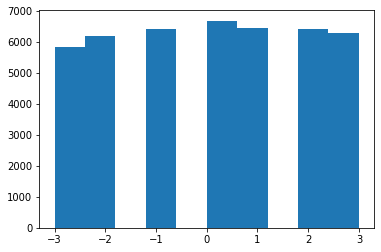

In [19]:
#np.histogram(total_sample)
plt.hist(total_sample)